In [1]:
import os
import difflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches as mpatches

import sys
sys.path.append('../../')
from rllte.evaluation.visualization import _annotate_and_decorate_axis, plot_interval_estimates
from rllte.evaluation import Performance
from utils import smooth

/Users/yuanmingqi/miniconda3/envs/rllte/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yuanmingqi/miniconda3/envs/rllte/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/yuanmingqi/miniconda3/envs/rllte/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yuanmingqi/miniconda3/envs/rllte/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/yuanmingqi/miniconda3/envs/rllte/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/yuanmingqi/mi

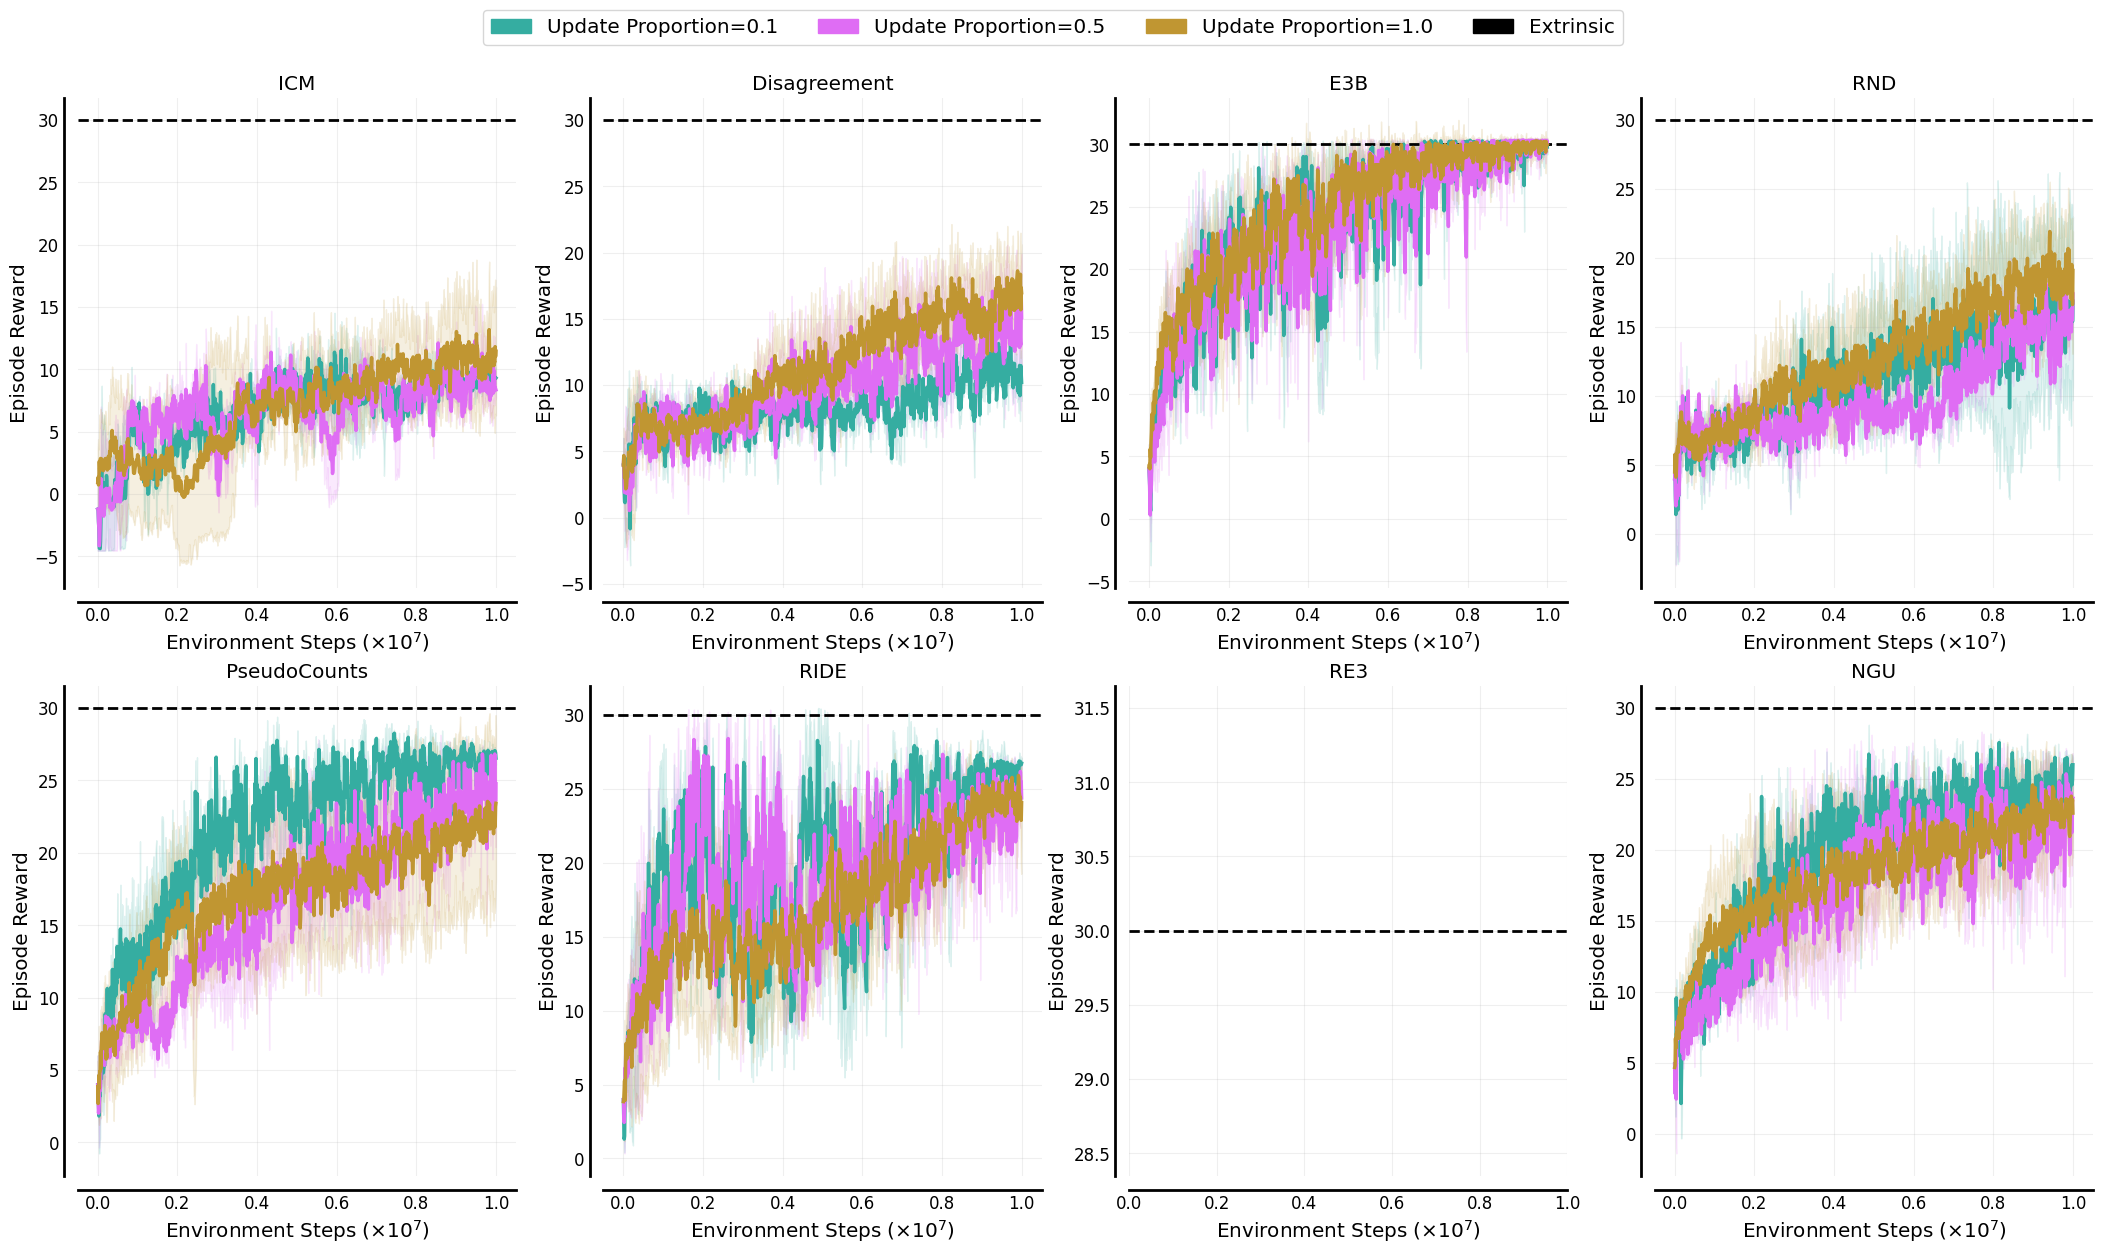

In [5]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'RE3', 'NGU']
candidates = ['01', '05', '10']
legends = ['Update Proportion=0.1', 'Update Proportion=0.5', 'Update Proportion=1.0', 'Extrinsic']
colors = sns.husl_palette(len(candidates), h=.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(candidates)]
fake_patches.append(mpatches.Patch(color='k', label="Extrinsic"))

fig, axes = plt.subplots(2, 4, figsize=(26, 14))

for subplot_idx, candidate in enumerate(candidates):
    root = f"/Users/yuanmingqi/Downloads/nips2024_data/q3_new/{candidate}/"
    num_points = 1000
    all_data = {algo: [] for algo in algos}

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                # data = smooth(data, 0.95)
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])
        # print(candidate, algo, all_data[algo].shape)

    for algo_idx, algo in enumerate(algos):
        mean, std = np.mean(all_data[algo], axis=0), np.std(all_data[algo], axis=0)
        ax = axes.flatten()[algo_idx]
        x = np.linspace(0, 1.0, num_points)
        if subplot_idx == 0:
            ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
        if algo != 'RE3':
            ax.plot(x, mean, linewidth=2.5, c=colors[subplot_idx], label=legends[subplot_idx])
            ax.fill_between(x, mean+std, mean-std, alpha=0.15, color=colors[subplot_idx])
        # ax.set_ylim(0, 10)
        ax.set_title(algos[algo_idx], fontsize="x-large")
        ax = _annotate_and_decorate_axis(ax, 
                                        ticklabelsize="large",
                                        xlabel=r"Environment Steps ($\times 10^7$)", 
                                        ylabel="Episode Reward",
                                        xticklabels=np.linspace(0, 1, num_points),
                                        )
        
fig.legend(fake_patches, legends, loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 0.95))
fig.savefig('figure_rq3_curves.pdf', bbox_inches='tight', dpi=300)

In [ ]:
algos = ['ICM', 'Disagreement', 'E3B', 'RND', 'PseudoCounts', 'RIDE', 'NGU']
titles = ['Update Proportion=0.1', 'Update Proportion=0.5', 'Update Proportion=1.0']
# colors = sns.color_palette("husl", len(algos))
colors = sns.husl_palette(len(algos), h=.5)
fake_patches = [mpatches.Patch(color=colors[i], label=alg) for i, alg in enumerate(algos)]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for subplot_idx, candidate in enumerate(['01', '05', '10']):
    root = f"./data/q3/{candidate}/"
    num_points = 10
    all_data = {algo: [] for algo in algos}

    ax = axes[subplot_idx]

    for algo in algos:
        for dir in os.listdir(root):
            if algo.lower() in dir:
                file = f"{root}/{dir}/"
                file = file + difflib.get_close_matches("2024-", os.listdir(file), 1, 0.1)[0] + '/train.log'
                data = pd.read_csv(file)['episode_reward']
                data = data[np.linspace(0, data.shape[0]-1, num_points, dtype=int)]
                data = smooth(data, 0.95)
                all_data[algo].append(data)

        all_data[algo] = np.array(all_data[algo])

    x = np.linspace(0, 1, num_points)
    ax.axhline(y=30.0, color='k', linestyle='--', linewidth=2, label="Extrinsic")
    for algo, color in zip(algos, colors):
        mean, std = np.mean(all_data[algo], axis=0), np.std(all_data[algo], axis=0)
        ax.plot(x, mean, linewidth=2.5, marker='o', markersize=6, c=color, label=algo)
        ax.fill_between(x, mean+std, mean-std, alpha=0.15, color=color)

    ax.set_title(titles[subplot_idx], fontsize="x-large")
    ax = _annotate_and_decorate_axis(ax, 
                                    ticklabelsize="large",
                                    xlabel=r"Environment Steps ($\times 10^7$)", 
                                    ylabel="Episode Reward",
                                    xticklabels=np.linspace(0, 1, num_points),
                                    )
fig.legend(fake_patches, algos, loc='upper center', 
    fancybox=True, ncol=len(algos), 
    fontsize='x-large',
    bbox_to_anchor=(0.5, 1.05))
fig.savefig('figure_rq3_curves.pdf', bbox_inches='tight', dpi=300)